#  Lunar Lander with SARSA($\lambda$) :

Author: Nirav Lad

This notebook implements [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) as available through [Farama Foundation Gymnasium](https://gymnasium.farama.org/).  The algorithm utilized is SARSA($\lambda$) as discussed in [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Sutton and Barto.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import gymnasium as gym

from typing import List, Tuple, Union, Callable
from numpy.typing import NDArray
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from gymnasium.wrappers import RecordVideo
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, concatenate_videoclips
from IPython.display import Video
import os
import shutil

## Define parameters

### Enviroment variables

In [2]:
ENV_NAME = 'LunarLander-v3'

In [3]:
A = np.arange(4)
cardA = 4
cardS = 8

### Hyperparameters

In [4]:
γ = 0.99
λ = 0
lr = (0.1, 0.9)

## Functions

### Mean and halfwidth calculation

In [5]:
def calculate_mean_hw( d: Union[List[np.float32] | NDArray[np.float32]], 
                       ci:int = 0.95 ) -> Tuple[np.float32, np.float32]:
    d = np.array( d )
    n = np.size( d )
    std_error = np.std( d, ddof=1 ) / np.sqrt(n)
    t_critical = stats.t.ppf( 1 - ( 1 - ci ) / 2, n - 1 )
    mean = np.mean( d ) 
    halfwidth = t_critical * std_error
    return( mean, halfwidth )

### Poilicy function ($\pi$)

$\pi(s) =\arg \max_{a \in \mathcal{A}} \Phi(s,a)^{\intercal} w$

In [6]:
def π( state:NDArray[np.float32], 
       w:NDArray[np.float32], 
       φ:Callable[[NDArray[np.float32], int], int] ) -> int:
    
    return( np.argmax([np.dot( φ(state, a), w ) for a in A]) )

### TD Learning rate/step size

The learning rate at episode $n$ with initial learnign rate $\alpha_a$ and learning rate decay $\alpha_b$ is defined as $\alpha_n =  a_{a}\left( \frac{1}{(1 + n)^{\alpha_{b}}} \right)$

In [7]:
α = lambda n: max( 0.01, lr[0] / ( n + 1 )**lr[1] )

### Evaluate policy

In [8]:
def evaluate_policy( w:NDArray[np.float32], 
                     φ:Callable[[NDArray[np.float32], int], int], 
                     num_evaluations:int = 10,
                     seed:int = 42,
                     enable_wind:bool = False ) -> Tuple[np.float32, np.float32]:
    
    env = gym.make(ENV_NAME, enable_wind=enable_wind)
    
    G = []

    for n in np.arange(num_evaluations):
        terminated = False
        truncated = False
        Gm = 0
        s,_ = env.reset( seed = int( seed * 1e2 + n * 3e4 ) )
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated,_ = env.step(a)
            s = sP
            Gm += r

        G.append(Gm)

    env.close()
    mean, hw = calculate_mean_hw(G)
    return( mean, hw )


### **SARSA**($\lambda$)

Algorithm taken from [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Sutton and Barto.

<b>Inputs</b>:
- $\pi$: Policy whose value function is sought
-  function $\hat{v}:S \times \mathbb{R}^d \rightarrow \mathbb{R}$

<b>Parameters</b>
- step size $\alpha > 0$, trace decay rate $\lambda \in [0,1]$

<b>algorithm</b>:<br>
01: Initialize value-function weights $\mathbf{w}$ (e.g. $\mathbf{w} = 0$)<br>
02: Loop for each episode:<br>
03: &nbsp;&nbsp;&nbsp;&nbsp;Initailize $S$<br>
04: &nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \gets \mathbf{0}$<br>
05: &nbsp;&nbsp;&nbsp;&nbsp;Loop for each step of episode:<br>
06: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose $A \sim \pi(\cdot | S)$<br>
07: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Take action $A$, observe $R, S'$<br>
08: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \gets \gamma \lambda \mathbf{z} + \nabla\hat{v}(S,\mathbf{w})$<br>
09: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta \gets R + \gamma \hat{v}(S',\mathbf{w}) - \hat{v}(S,\mathbf{w})$<br>
10: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{w} \gets \mathbf{w} + \alpha \delta \mathbf{z}$<br>
11: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \gets S'$<br>
12: &nbsp;&nbsp;&nbsp;&nbsp;Until $S'$ is terminal


In [9]:
def SARSAλ( w:NDArray[np.float32], 
                φ:Callable[ [NDArray[np.float32], int], int ], 
                M:int = 500, 
                seed:int = 1982, 
                enable_wind:bool=False ) -> NDArray[np.float32]:

    env = gym.make(ENV_NAME, enable_wind=enable_wind)

    d = []
    
    wP = w

    for m in tqdm( np.arange(M) ):

        z = np.zeros_like( w )

        terminated = False
        truncated = False
        s,_ = env.reset(seed=int(m * 1e5 + seed * 2e3))
        np.random.seed(seed=int(m * 1e5 + seed * 2e3) )
        

        while not(terminated or truncated):
            
            # Choose action using ε-method  
            if ( np.random.rand() < 0.05 ):
                a = np.random.randint(cardA)
            else:
                a = π( s, w, φ )
                
            sP, r, terminated, truncated, _ = env.step(a)
            aP = π( sP, w, φ )

            z = γ * λ * z + φ( s, a )
            V = np.dot( w, φ( s, a ) )
            Vp = np.dot( w, φ( sP, aP ) ) * ( 1 - terminated )
            
            wP = wP + α(m) * (r + γ * Vp - V) * z 
            
            s = sP
            a = aP
            
        w = wP

        μ, δ = evaluate_policy( w, φ, seed=seed, enable_wind=enable_wind )
        score = μ - δ 
        d.append({'episode':m, 'score': score, 'mean': μ, 'halfwidth': δ, 'w': w.copy()})
        tqdm.write(f"Episode{m:3d}:\t{score:.2f}\t({μ:3.2f} ± {δ:3.2f})")

    env.close()

    policies = pd.DataFrame( d )

    return( policies )


### Record policy video

In [10]:
def record_policy( w:NDArray[np.float32], 
                   φ:Callable[[NDArray[np.float32], int],int],
                   title:str, 
                   M:int = 10, 
                   seed:int = 1776,
                   enable_wind = False ) -> str:

    import warnings
    warnings.filterwarnings("ignore", message=".*Overwriting existing videos.*")
    os.makedirs("videos", exist_ok=True)
    env = gym.make(ENV_NAME, render_mode="rgb_array", enable_wind=enable_wind)
    env = RecordVideo(env, video_folder="videos", episode_trigger=lambda ep: True)

    G = []

    for m in np.arange(M):

        Gm = 0
        s, _ = env.reset(seed= int( seed + m * 1e4 ) )
        terminated = False
        truncated = False
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r
        
        G.append( Gm )

    μ, δ = calculate_mean_hw( G )
    score = μ - δ

    env.close()

    video_files = sorted([f for f in os.listdir("videos") if f.endswith(".mp4")])
    annotated_clips = []
    for i, vf in enumerate(video_files):
        clip = VideoFileClip(f"videos/{vf}", )
        
        txt = TextClip( text=f"{title}\nEP {i+1:2d} Reward: {G[i]:0.1f}\nScore: {score:0.1f} ({μ:0.1f} ± {δ:0.1f})", 
                        font_size=14, 
                        color='white', 
                        method='caption',
                        vertical_align='left', horizontal_align='top',
                        size = (clip.w, 60) )
        txt = txt.with_duration(clip.duration)
        
        annotated_clip = CompositeVideoClip([clip, txt])
        annotated_clips.append(annotated_clip)

    final_clip = concatenate_videoclips(annotated_clips )

    fname = f"best_policy_({score:0.1f}).mp4"
    final_clip.write_videofile(fname)

    shutil.rmtree("videos")

    return( fname )

## Run **SARSA**($\lambda$)

### Feature vectors

In [11]:
def simple(state, action):
    x = state
    fv = np.hstack([x * (action == a) for a in A ])
    return( fv )

In [12]:
def interactions(state,action):
    px, py, vx, vy, θ, ω, lf, rf = state

    interactions = np.array([px*py, px*vx, px*θ, px*ω, px*lf, px*rf,
                             py*vx, py*vy, py*θ, py*ω, py*lf, py*rf,
                             vx*vy, vx*θ, vx*ω, vx*lf, vx*rf,
                             vy*θ, vy*ω, vy*lf, vy*rf,
                             θ*ω, θ*lf, θ*rf,
                             θ*lf, θ*rf,
                             lf*rf])

    x = np.hstack(( state, interactions ))
    fv = np.hstack([x * (action == a) for a in A ])

    return( fv)

In [ ]:
f = interactions
k = len( f( np.zeros(cardS), 0 ) )
w = np.zeros( k )
policies = SARSAλ( w, M=200, φ=f, seed=1982, enable_wind=False )

  0%|          | 0/200 [00:00<?, ?it/s]

Episode  0:	-526.76	(-469.63 ± 57.13)
Episode  1:	-679.70	(-578.43 ± 101.26)
Episode  2:	-188.03	(-123.89 ± 64.14)
Episode  3:	-365.43	(-283.65 ± 81.78)
Episode  4:	-713.06	(-563.12 ± 149.94)
Episode  5:	-712.58	(-587.80 ± 124.78)
Episode  6:	-74.96	(-4.05 ± 70.91)
Episode  7:	-61.03	(33.87 ± 94.89)
Episode  8:	-54.30	(38.97 ± 93.27)
Episode  9:	-44.15	(56.38 ± 100.53)
Episode 10:	-66.69	(18.86 ± 85.55)
Episode 11:	-33.67	(55.35 ± 89.01)
Episode 12:	-51.36	(26.84 ± 78.20)
Episode 13:	-52.40	(33.51 ± 85.90)
Episode 14:	-28.50	(45.80 ± 74.30)
Episode 15:	-11.91	(73.19 ± 85.10)
Episode 16:	-33.99	(51.82 ± 85.81)
Episode 17:	-17.68	(56.41 ± 74.08)
Episode 18:	-5.65	(77.18 ± 82.83)
Episode 19:	19.17	(104.43 ± 85.26)
Episode 20:	-12.87	(70.29 ± 83.16)
Episode 21:	58.69	(123.96 ± 65.26)
Episode 22:	77.10	(137.23 ± 60.13)
Episode 23:	43.58	(115.39 ± 71.80)
Episode 24:	70.96	(154.20 ± 83.25)
Episode 25:	94.99	(169.71 ± 74.72)
Episode 26:	55.94	(137.06 ± 81.12)
Episode 27:	44.21	(152.70 ± 108.49

### Plot learning curve

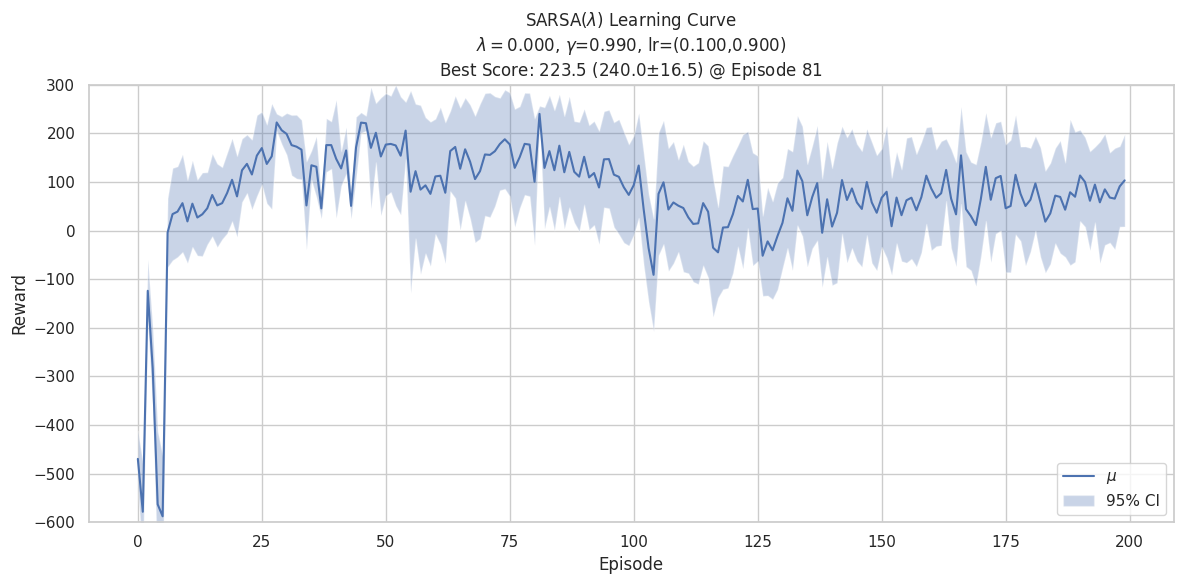

In [14]:
plt.figure(figsize=(12, 6))  
sns.set_theme(style="whitegrid") 
sns.lineplot(data=policies, x='episode', y='mean', label="$\mu$")
plt.fill_between( policies['episode'],
                  policies['mean'] - policies['halfwidth'],
                  policies['mean'] + policies['halfwidth'],
                  alpha=0.3,
                  label='95% CI')

policies.sort_values(by='score', ascending=False, inplace=True)
p = policies.iloc[0]

plt.title(f"SARSA($\\lambda$) Learning Curve\n" +\
          f"$\\lambda={λ:.3f}$, $\\gamma$={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})\n" + \
          f"Best Score: {p['score']:.1f} ({p['mean']:.1f}$\\pm${p['halfwidth']:.1f}) @ Episode {p['episode']}" )
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(-600, 300)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"learning_curve.pdf")

plt.show()

### Determine best policy ($w^*$)

In [15]:
best_score = -np.inf
num_best_policies = 10
print(f"EVALUATING TOP {num_best_policies} POLICES")
print("\t\tScore\t(μ ± δ)")
for i, p in policies.head(num_best_policies).iterrows():
    μ, δ = evaluate_policy(p['w'], f, num_evaluations=30, seed=1776, enable_wind=False)
    score = μ - δ
    print(f"Episode {i:3d}\t{score:.1f}\t({μ:.1f} ± {δ:.1f})")
    if ( best_score < score ):
        best_score = score
        w_star = p['w']
        m_star = p['episode']

print(f"SUPERLATIVE POLICY:\tEPISODE {m_star}")

EVALUATING TOP 10 POLICES
		Score	(μ ± δ)
Episode  81	136.4	(184.9 ± 48.5)
Episode  46	172.7	(201.0 ± 28.3)
Episode  28	128.4	(161.9 ± 33.4)
Episode  45	127.0	(178.4 ± 51.5)
Episode  29	116.8	(153.3 ± 36.5)
Episode  30	123.5	(157.1 ± 33.7)
Episode  54	101.5	(159.8 ± 58.4)
Episode  48	106.0	(165.7 ± 59.8)
Episode  39	119.2	(146.1 ± 26.9)
Episode  38	87.7	(120.9 ± 33.3)
SUPERLATIVE POLICY:	EPISODE 46


### The superlative policy $w^*$ weights

In [16]:
np.set_printoptions(precision=2)
print(f"w*:")
print( w_star.reshape(-1,4) )

w*:
[[-1.35e+00 -6.40e+00 -1.05e+00  1.39e+01]
 [ 6.04e-01  6.41e+00 -2.04e+00 -9.70e-02]
 [ 8.36e-01 -1.87e+00  1.32e+00  3.93e+00]
 [-3.89e-01  8.36e-02 -9.40e-01  3.01e-01]
 [-5.62e-01 -1.83e+00  1.89e-01  1.52e-01]
 [ 3.17e+00  1.16e+00  7.17e+00 -2.56e-01]
 [ 8.08e-01 -2.16e+00 -9.24e+00  1.98e+01]
 [ 1.81e+01 -9.99e+00  6.90e-01 -8.35e-01]
 [ 6.90e-01 -8.35e-01 -1.82e+00  3.40e+00]
 [-5.51e+00  7.94e+00  1.21e+01 -1.13e+01]
 [-1.09e+01 -3.93e+00 -1.87e+00  1.96e+00]
 [-3.35e+00  7.02e+00  4.79e+00  8.38e-01]
 [-2.73e-02  5.05e+00  3.77e+00 -5.69e+00]
 [-5.99e+00  1.79e-01  1.64e-01 -5.58e+00]
 [ 1.46e+01  1.26e+01  7.35e-01  2.13e-01]
 [ 1.73e+01  1.82e+01  2.20e-01  1.85e-01]
 [-4.38e+01 -1.53e+00 -4.74e-03 -1.53e+00]
 [-4.74e-03 -7.83e+00 -2.47e+00 -6.97e+01]
 [-2.72e+00 -5.72e+01  6.25e+00  3.43e+00]
 [-4.88e+00 -6.04e+00 -3.46e+01 -1.04e+02]
 [ 3.79e+01  1.02e+01  1.35e-01 -7.44e-01]
 [-8.72e+01 -9.64e+01  3.76e+01  9.90e+00]
 [-3.02e-01 -1.67e-01 -5.13e+01  1.17e+02]
 [ 3.33

### View video recording of the best policy

In [ ]:
title = f"SARSA, LAMBA={λ:0.3f}, GAMMA={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})"
video_filename = record_policy( w_star, interactions, title, enable_wind=False )
print(f"Done! Video saved to {video_filename}")

MoviePy - Building video best_policy_(210.9).mp4.
MoviePy - Writing video best_policy_(210.9).mp4



frame_index:  28%|██▊       | 1160/4098 [00:16<00:37, 77.93it/s, now=None]/usr/local/lib/python3.11/site-packages/moviepy/video/io/ffmpeg_reader.py:190: UserWarning: In file videos/rl-video-episode-2.mp4, 720000 bytes wanted but 0 bytes read at frame index 372 (out of a total 372 frames), at time 7.44/7.44 sec. Using the last valid frame instead.
  warnings.warn(
frame_index:  57%|█████▋    | 2348/4098 [00:33<00:26, 65.84it/s, now=None]

In [ ]:
Video(video_filename, embed=True)